In [1]:
import numpy as np 
import pandas as pd 

from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
import seaborn as sns
sns.set(style="white") #white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
#from xgboost import XGBRegressor as XGBR
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold, cross_val_score as CVS, train_test_split as TTS
#import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_curve, auc, accuracy_score)
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
#import xgboost as xgb
#from xgboost import XGBClassifier as XGBC

In [2]:
train_df = pd.read_csv(r"C:\Users\xuhan\Desktop\我的坚果云\Sys_learning\4_\titanic\train.csv")
test_df = pd.read_csv(r"C:\Users\xuhan\Desktop\我的坚果云\Sys_learning\4_\titanic\test.csv")

In [26]:
train_df = pd.read_csv(r"/Users/xuhan/Nutstore Files/我的坚果云/Sys_learning/4_/titanic/train.csv")
test_df = pd.read_csv(r"/Users/xuhan/Nutstore Files/我的坚果云/Sys_learning/4_/titanic/test.csv")

In [3]:
all_df = train_df.append(test_df)
all_df['Fare'].fillna(all_df['Fare'].median(), inplace=True)

X_all = all_df.drop(columns=['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin'])
y = train_df['Survived']

In [4]:
all_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# Numbers of people sharing tickets
all_df['Ticket_shared_by'] = all_df['Ticket'].apply(lambda x: (all_df['Ticket'] == x).sum())

# Title from Name
all_df['Title'] = all_df['Name'].str.extract('([A-Za-z]+)\.', expand=True)
mapping = {'Mlle': 'Miss', 'Major': 'Mr', 'Col': 'Mr', 'Sir': 'Mr', 'Don': 'Mr', 'Mme': 'Miss',
          'Jonkheer': 'Mr', 'Lady': 'Mrs', 'Capt': 'Mr', 'Countess': 'Mrs', 'Ms': 'Miss', 'Dona': 'Mrs'}
all_df['Title'].replace(mapping, inplace=True)

# Imputation of Age using Title
median_ages_by_titles = all_df.groupby('Title')['Age'].median()
for title in all_df['Title'].unique():
    age_to_impute = median_ages_by_titles[title]
    all_df.loc[(all_df['Age'].isnull()) & (all_df['Title'] == title), 'Age'] = age_to_impute

# Binning
all_df['FareBin'] = pd.qcut(X_all['Fare'], 5, labels=[1,2,3,4,5])
all_df['AgeBin'] = pd.qcut(X_all['Age'], 4,labels=[1,2,3,4])

# Family size
all_df['Family_Size'] = all_df['Parch'] + all_df['SibSp']

# Family survival
all_df['Last_Name'] = all_df['Name'].apply(lambda x: x.split(",")[0])

all_df['Family_Survival'] = 0.5 # Default value

for _, grp_df in all_df.groupby(['Last_Name', 'Fare']): 
    if len(grp_df) != 1:
        for ind, row in grp_df.iterrows():
            smax = grp_df.drop(ind)['Survived'].max()
            smin = grp_df.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            if smax == 1:
                all_df.loc[all_df['PassengerId'] == passID, 'Family_Survival'] = 1
            elif smin == 0:
                all_df.loc[all_df['PassengerId'] == passID, 'Family_Survival'] = 0

for _, grp_df in all_df.groupby('Ticket'):
    if len(grp_df) != 1:
        for ind, row in grp_df.iterrows():
            if row['Family_Survival'] < 1:
                smax = grp_df.drop(ind)['Survived'].max()
                smin = grp_df.drop(ind)['Survived'].min()
                passID = row['PassengerId']
                if smax == 1:
                    all_df.loc[all_df['PassengerId'] == passID, 'Family_Survival'] = 1
                elif smin == 0:
                    all_df.loc[all_df['PassengerId'] == passID, 'Family_Survival'] = 0

#X_all['Family_Survival'] = all_df['Family_Survival']

In [6]:
train_data = all_df[:train_df.shape[0]]
test_data = all_df[train_df.shape[0]:]
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_shared_by,Title,FareBin,AgeBin,Family_Size,Last_Name,Family_Survival
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,Mr,1,2,1,Braund,0.5
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,Mrs,5,3,1,Cumings,0.5
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,Miss,2,2,0,Heikkinen,0.5
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2,Mrs,5,3,1,Futrelle,0.0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,Mr,2,3,0,Allen,0.5


In [7]:
train_data = train_data.copy()
train_data["Age"].fillna(train_df["Age"].median(skipna=True), inplace=True)
train_data["Embarked"].fillna(train_df['Embarked'].value_counts().idxmax(), inplace=True)
train_data["AgeBin"] = train_data["AgeBin"].astype('float32')
train_data["FareBin"] = train_data["FareBin"].astype('float32')
train_data["AgeBin"].fillna(train_data["AgeBin"].median(skipna=True), inplace=True)
train_data.drop('Cabin', axis=1, inplace=True)
train_data['TravelAlone']=np.where((train_data["SibSp"]+train_data["Parch"])>0, 0, 1)
train_data.drop('SibSp', axis=1, inplace=True)
train_data.drop('Parch', axis=1, inplace=True)
training=pd.get_dummies(train_data, columns=["Pclass","Embarked","Sex"])#进行独热编码
training.drop('Sex_female', axis=1, inplace=True)
training.drop('PassengerId', axis=1, inplace=True)
training.drop('Name', axis=1, inplace=True)
training.drop('Ticket', axis=1, inplace=True)

test_data = test_data.copy()
test_data["Age"].fillna(train_df["Age"].median(skipna=True), inplace=True)
test_data["Fare"].fillna(train_df["Fare"].median(skipna=True), inplace=True)
test_data["AgeBin"] = test_data["AgeBin"].astype('float32')
test_data["FareBin"] = test_data["FareBin"].astype('float32')
test_data["AgeBin"].fillna(test_data["AgeBin"].median(skipna=True), inplace=True)
test_data.drop('Cabin', axis=1, inplace=True)
test_data['TravelAlone']=np.where((test_data["SibSp"]+test_data["Parch"])>0, 0, 1)
test_data.drop('SibSp', axis=1, inplace=True)
test_data.drop('Parch', axis=1, inplace=True)
testing = pd.get_dummies(test_data, columns=["Pclass","Embarked","Sex"])
testing.drop('Sex_female', axis=1, inplace=True)
testing.drop('PassengerId', axis=1, inplace=True)
testing.drop('Name', axis=1, inplace=True)
testing.drop('Ticket', axis=1, inplace=True)

final_test = testing
final_train = training

final_train['IsMinor']=np.where(final_train['Age']<=16, 1, 0)
final_train.drop('Title', axis=1, inplace=True)
final_train.drop('Last_Name', axis=1, inplace=True)
final_test['IsMinor']=np.where(final_test['Age']<=16, 1, 0)
final_test.drop('Title', axis=1, inplace=True)
final_test.drop('Last_Name', axis=1, inplace=True)

In [8]:
final_train

,Survived,Age,Fare,Ticket_shared_by,FareBin,AgeBin,Family_Size,Family_Survival,TravelAlone,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_male,IsMinor
0,0.0,22.0,7.2500,1,1.0,2.0,1,0.5,0,0,0,1,0,0,1,1,0
1,1.0,38.0,71.2833,2,5.0,3.0,1,0.5,0,1,0,0,1,0,0,0,0
2,1.0,26.0,7.9250,1,2.0,2.0,0,0.5,1,0,0,1,0,0,1,0,0
3,1.0,35.0,53.1000,2,5.0,3.0,1,0.0,0,1,0,0,0,0,1,0,0
4,0.0,35.0,8.0500,1,2.0,3.0,0,0.5,1,0,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.0,27.0,13.0000,1,3.0,2.0,0,0.5,1,0,1,0,0,0,1,1,0
887,1.0,19.0,30.0000,1,4.0,1.0,0,0.5,1,1,0,0,0,0,1,0,0
888,0.0,22.0,23.4500,4,4.0,2.0,3,0.0,0,0,0,1,0,0,1,0,0
889,1.0,26.0,30.0000,1,4.0,2.0,0,0.5,1,1,0,0,1,0,0,1,0


In [9]:
cols = ["Age","Fare","TravelAlone","Pclass_1","Pclass_2","Embarked_C","Embarked_S","Sex_male","IsMinor"
       ,"Ticket_shared_by"
        ,"FareBin"
        ,"AgeBin"
        ,"Family_Size","Family_Survival","TravelAlone"] 
X = final_train[cols]
y = final_train['Survived']

In [10]:
rf = RandomForestClassifier(random_state = 0
                            ,n_estimators = 13
                            ,max_depth = 86
                            ,min_samples_leaf = 3
                            ,min_samples_split = 10
                            ,max_features = 7
                            ,max_leaf_nodes = 55
                            ,criterion = 'gini'
                            )
lr = LogisticRegression(C=4.1,random_state = 0,
                        max_iter = 10000)
clf = GradientBoostingClassifier(n_estimators = 10,learning_rate = 0.1,max_depth = 3)

In [42]:
'''
params = {
    'booster': 'gbtree',
    'objective': 'multi:softmax',
    'num_class': 3,
    'gamma': 0.1,
    'max_depth': 6,
    'lambda': 2,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3,
    'slient': 1,
    'eta': 0.1
}
dtrain = xgb.DMatrix(X,y)
num_rounds = 500
xgb1 = xgb.train(params,dtrain,num_rounds)

reg = XGBC(n_estimators=5
          ,subsample = 1
          ,learning_rate = 0.75).fit(X,y)

mdl = lgb.LGBMClassifier(boosting_type= 'gbdt',
                         objective = 'binary',
                         n_jobs = 3, # Updated from 'nthread'
                         silent = True,
                         max_depth = -1,
                         max_bin = 512,
                         subsample_for_bin = 200,
                         subsample_freq = 1,
                         min_split_gain = 0.5,
                         min_child_weight = 1,
                         min_child_samples = 5,
                         scale_pos_weight = 1,
                         learning_rate = 0.005,
                         n_estimators = 40,
                         num_leaves = 6,
                         colsample_bytree = 0.65,
                         subsample = 0.7,
                         reg_alpha = 1,
                         reg_lambda = 1,
                        )
'''

In [11]:
eclf1 = VotingClassifier(estimators=[('lr', lr)
                                     , ('rf', rf)
                                     , ('clf', clf)
                                     #, ('reg', reg)
                                     #,('mdl', mdl)
                                     #,('xgb',xgb1)
                                    ]
                         ,voting = 'soft'
                        )
eclf = eclf1.fit(X,y)

In [12]:

clf = clf.fit(X,y)
rf = rf.fit(X,y)
lr = lr.fit(X,y)
#reg = reg.fit(X,y)
#mdl = mdl.fit(X,y)

In [67]:
def plot_learning_curve(estimator,title, X, y,
                        ax=None, #选择子图
                        ylim=None, #设置纵坐标的取值范围
                        cv=None, #交叉验证
                        n_jobs=None #设定索要使用的线程
                       ):
    from sklearn.model_selection import learning_curve
    import matplotlib.pyplot as plt
    import numpy as np
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y
                                                            ,shuffle=True
                                                            ,cv=cv
                                                            #,random_state=420
                                                            ,n_jobs=n_jobs)
    if ax == None:
        ax = plt.gca()
    else:
        ax = plt.figure()
        ax.set_title(title)
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    ax.grid() #绘制网格，不是必须
    ax.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color="r",label="Training score")
    ax.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color="g",label="Test score")
    ax.legend(loc="best")
    return ax

[11:57:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:57:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:57:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:57:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

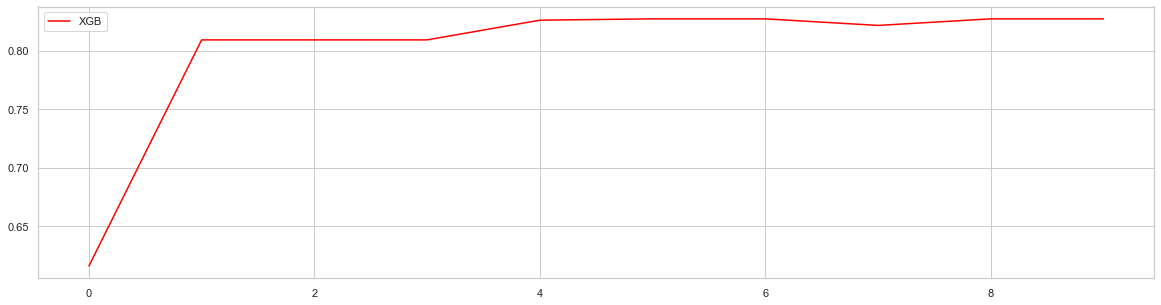

In [72]:
axisx = range(0,10,1)
rs = []
cv = KFold(n_splits=5, shuffle = True, random_state=42)
for i in axisx:
    reg = XGBC(n_estimators=i,random_state=420)
    rs.append(CVS(reg,X,y,cv=cv).mean())
print(axisx[rs.index(max(rs))],max(rs))
plt.figure(figsize=(20,5))
plt.plot(axisx,rs,c="red",label="XGB")
plt.legend()
plt.show()

[12:04:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:04:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:04:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:04:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

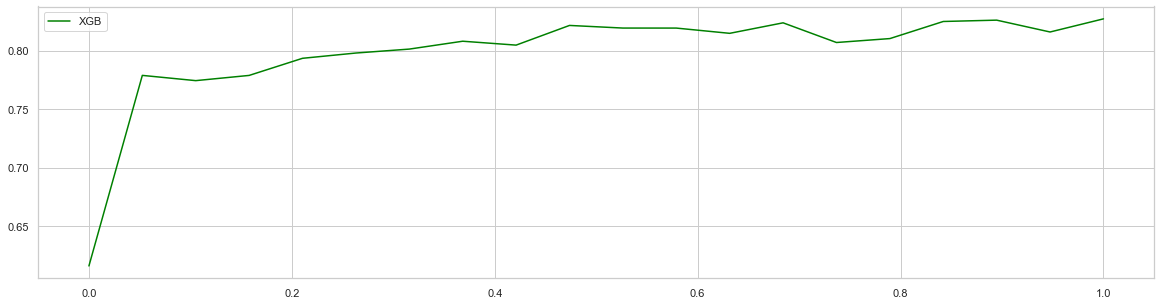

In [80]:
axisx = np.linspace(0,1,20)
rs = []
for i in axisx:
    reg = XGBC(n_estimators=5,subsample=i,random_state=420)
    rs.append(CVS(reg,X,y,cv=cv).mean())
print(axisx[rs.index(max(rs))],max(rs))
plt.figure(figsize=(20,5))
plt.plot(axisx,rs,c="green",label="XGB")
plt.legend()
plt.show()

[12:13:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:13:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:13:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:13:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

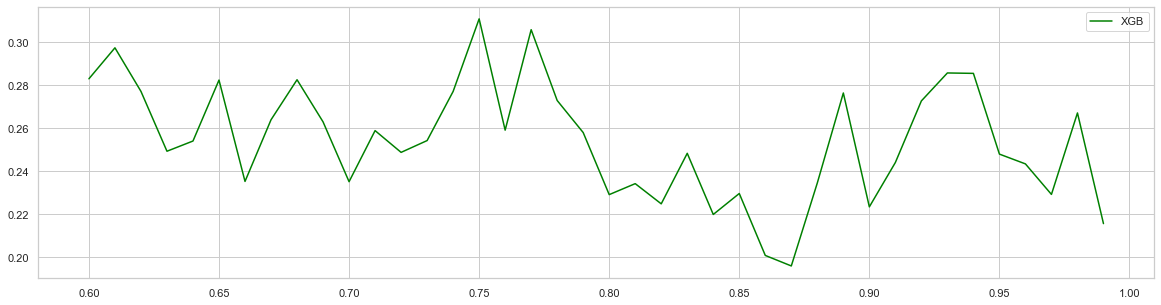

In [89]:
axisx = np.arange(0.6,1,0.01)
rs = []
def regassess(reg,Xtrain,Ytrain,cv,scoring = ["r2"],show=True):
    score = []
    for i in range(len(scoring)):
        if show:
            print("{}:{:.2f}".format(scoring[i]
                                     ,CVS(reg
                                          ,Xtrain
                                          ,Ytrain
                                          ,cv=cv
                                          ,scoring=scoring[i]).mean()))
        score.append(CVS(reg,Xtrain,Ytrain,cv=cv,scoring=scoring[i]).mean())
    return score
for i in axisx:
    reg = XGBC(n_estimators=5,random_state=420,learning_rate=i)
    score = regassess(reg,X,y,cv,scoring = ["r2","neg_mean_squared_error"],show=False)
    rs.append(score[0])
    #te.append(test)
print(axisx[rs.index(max(rs))],max(rs))
plt.figure(figsize=(20,5))
#plt.plot(axisx,te,c="gray",label="XGB")
plt.plot(axisx,rs,c="green",label="XGB")
plt.legend()
plt.show()

In [13]:
p_predproba = (rf.predict_proba(final_test[cols]) 
              +clf.predict_proba(final_test[cols])
              +lr.predict_proba(final_test[cols])
              +reg.predict_proba(final_test[cols])
              ) * 0.25

NameError: name 'reg' is not defined

In [14]:
final_test['Survived'] = eclf.predict(final_test[cols])
final_test['PassengerId'] = test_df['PassengerId']

for col in ['Survived']:
    final_test[col] = final_test[col].apply(lambda x: int(x))


submission = final_test[['PassengerId','Survived']]
submission.to_csv("submission_6.csv", index=False)
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
